In [1]:
%load_ext autoreload
%autoreload 2

# 3rd party imports
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm
import nibabel as nib


# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian
import modules.correspondences as correspondences

## Functions

In [5]:
def get_neighborhood(point, points, max_dist):
    # Get the Euclidean distance between the point and all other points
    distances = np.linalg.norm(points - point, axis=1)
    
    # Get the indices of the points within the neighborhood
    neighborhood_indices = np.where(distances <= max_dist)[0]
    
    # Get the points within the neighborhood
    neighborhood = points[neighborhood_indices]
    
    #neighborhood = [pt for pt in neighborhood if pt != point]
    
    return neighborhood_indices, neighborhood


def get_magnitude(v):
    return np.linalg.norm(v)


def angle_between_vectors(v1, v2):
    # arccos (A dot B / |A||B|)
    # Compute the dot product
    dot_product = np.dot(v1, v2)
    
    # Compute the magnitudes of the vectors
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    
    if magnitude_v1 == 0 or magnitude_v2 == 0:
        return 0, 0
    
    # Compute the cosine of the angle
    cos_theta = dot_product / (magnitude_v1 * magnitude_v2)
    
    # Clip the cosine value to the range [-1, 1] to avoid numerical issues
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Compute the angle in radians
    angle_rad = np.arccos(cos_theta)
    
    # Convert the angle to degrees
    angle_deg = np.degrees(angle_rad)
    
    return angle_rad, angle_deg

m1 = np.array([0, 1, 0])
f1 = np.array([0, 1, 4])

m2 = np.array([0, 3, 0])
f2 = np.array([0, 4, 4])

# Example vectors
# v1 = np.array([1, 0, 0])
# v2 = np.array([1, 0.5, 0])

v1 = f1 - m1
v2 = f2 - m2

# Compute the angle between the vectors
angle_rad, angle_deg = angle_between_vectors(v1, v2)

# Check if the angle exceeds a certain threshold (e.g., 45 degrees)
threshold_deg = 45
if angle_deg > threshold_deg:
    print(f"The vectors differ by a lot: {angle_deg:.2f} degrees")
else:
    print(f"The vectors do not differ by a lot: {angle_deg:.2f} degrees")
    
    
def remove_intersections(mpoints: np.ndarray, fpoints: np.ndarray) -> tuple:
    """
    Remove intersecting correspondences between the moving and fixed points.
    
    Parameters:
    mpoints (np.ndarray): The moving points.
    fpoints (np.ndarray): The fixed points.
    idx (int): The index of the correspondences.
    
    Returns:
    tuple: The moving and fixed correspondences with intersecting points removed.
    """
    mcorrespondences = []
    fcorrespondences = []

    max_index = int(max(np.unique(mpoints[:, 0])) + 1)
    for i in tqdm(range(max_index)):
        mpts = mpoints.copy()[mpoints[:, 0] == i][:, 1:]
        fpts = fpoints.copy()[fpoints[:, 0] == i][:, 1:]

        # Swap correspondences if they intersect
        fpts, ipts = correspondences.swap_correspondences(mpts, fpts)
        min_intersection_count = len(ipts)
        curr_fpts = fpts
        # Keep swapping until the number of intersections no longer decreases
        while True:
            fpts, ipts_temp = correspondences.swap_correspondences(mpts, fpts)
            intersection_count = len(ipts_temp)
            #print("Number of intersecting points:", intersection_count)
            if intersection_count < min_intersection_count:
                min_intersection_count = intersection_count
                curr_fpts = fpts
            else:
                break
        fpts = curr_fpts

        # Detect intersecting line segments
        intersecting_indices, intersecting_segments, swapped_segments = correspondences.detect_intersecting_segments(mpts, fpts)

        # Remove intersecting segments from correspondences
        new_mpts = mpts.copy()
        new_fpts = fpts.copy()
        while len(intersecting_indices) != 0:
            new_mpts = [element for i, element in enumerate(new_mpts) if i not in intersecting_indices[:, 0]]
            new_fpts = [element for i, element in enumerate(new_fpts) if i not in intersecting_indices[:, 0]]
            intersecting_indices, intersecting_segments, swapped_segments = correspondences.detect_intersecting_segments(new_mpts, new_fpts)
            num_intersections = len(intersecting_indices)
            #print("Number of intersecting segments left:", num_intersections)
            if num_intersections != 0:
                intersecting_indices, intersecting_segments, swapped_segments = correspondences.detect_intersecting_segments(new_mpts, new_fpts)
        new_mpts = np.array(new_mpts)
        new_fpts = np.array(new_fpts)


        new_col = np.full((new_mpts.shape[0], 1), i)
        new_mpts = np.hstack((new_col, new_mpts))
        new_fpts = np.hstack((new_col, new_fpts))
        mcorrespondences.append(new_mpts)
        fcorrespondences.append(new_fpts)

    mcorrespondences = np.concatenate(mcorrespondences, axis=0)
    fcorrespondences = np.concatenate(fcorrespondences, axis=0)
    return mcorrespondences, fcorrespondences


The vectors do not differ by a lot: 14.04 degrees


## Load deformation field

In [3]:
CURR_IDX = [345, 346]  # Only consider the correspondences of this index

# Input parameters
base_path = "data/base_unique_correspondences/registered_output/deformation3d.npy"
mpoints_path = "data/base_unique_correspondences/mpoints.npy"
fpoints_path = "data/base_unique_correspondences/fpoints.npy"

# Load the numpy array and compute the jacobian determinant
mpoints = np.load(mpoints_path)
fpoints = np.load(fpoints_path)

# Get only elements that are of the current index
mpts_array = []
fpts_array = []
for i in range(345, 355):
    m = mpoints[mpoints[:, 0] == i]
    f = fpoints[fpoints[:, 0] == i]
    mpts_array.append(m)
    fpts_array.append(f)

mpoints = np.vstack(mpts_array)
fpoints = np.vstack(fpts_array)
# Change the 0th index in each element to 0
mpoints[:, 0] -= 345
fpoints[:, 0] -= 345

cvectors = fpoints - mpoints  # Correspondence vectors

print("Correspondence point shape:", fpoints.shape)
print("First five fixed points:\n", fpoints[:5])
print("First five moving points:\n", mpoints[:5])
print("First five correspondence vectors:\n", cvectors[:5])

print("\n\nLast five fixed points:\n", fpoints[-5:])
print("Last five moving points:\n", mpoints[-5:])
print("Last five correspondence vectors:\n", cvectors[-5:])

Correspondence point shape: (12882, 3)
First five fixed points:
 [[  0.   9. 175.]
 [  0.   9. 176.]
 [  0.   9. 177.]
 [  0.   9. 182.]
 [  0.   9. 183.]]
First five moving points:
 [[  0.  15. 175.]
 [  0.  14. 179.]
 [  0.  14. 181.]
 [  0.  14. 182.]
 [  0.  14. 183.]]
First five correspondence vectors:
 [[ 0. -6.  0.]
 [ 0. -5. -3.]
 [ 0. -5. -4.]
 [ 0. -5.  0.]
 [ 0. -5.  0.]]


Last five fixed points:
 [[  9. 268. 245.]
 [  9. 268. 246.]
 [  9. 268. 247.]
 [  9. 268. 248.]
 [  9. 268. 251.]]
Last five moving points:
 [[  9. 268. 245.]
 [  9. 268. 246.]
 [  9. 268. 247.]
 [  9. 268. 248.]
 [  9. 267. 253.]]
Last five correspondence vectors:
 [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  1. -2.]]


## Remove INTERSECTING correspondences

In [5]:

# Remove intersecting correspondences
mpoints_intersection_removed, fpoints_intersection_removed = remove_intersections(mpoints, fpoints)
print("Starting number of correspondences:", mpoints.shape[0])
print("Number of correspondences after removing intersections:", mpoints_intersection_removed.shape[0])
print("Number of correspondences removed:", mpoints.shape[0] - mpoints_intersection_removed.shape[0])

100%|██████████| 10/10 [10:03<00:00, 60.40s/it]

Starting number of correspondences: 12882
Number of correspondences after removing intersections: 11981
Number of correspondences removed: 901


In [6]:
np.save("data/base_unique_correspondences/mpoints_intersection_removed_10.npy", mpoints_intersection_removed)
np.save("data/base_unique_correspondences/fpoints_intersection_removed_10.npy", fpoints_intersection_removed)

## Compute Jacobian of points with INTERSECTIONS removed.

fdata.shape (10, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.35901665687561035s
Computing dy
dy calculated in 3.426859140396118s
Computing dx
dx calculated in 6.09916353225708s
SITK deformation shape: (10, 320, 456, 3)
fdata.shape (10, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.3521692752838135s
Computing dy
dy calculated in 3.5086684226989746s
Computing dx
dx calculated in 6.2588489055633545s
SITK deformation shape: (10, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 5204
Before - minimum Jacobian determinant: -12.192625569400679
Before - maximum Jacobian determinant: 19.715043331253668

After - number of negative or zero Jacobian determinants: 3340
After - minimum Jacobian determinant: -12.060650694994253
After - maximum Jacobian determinant: 19.549333036006978


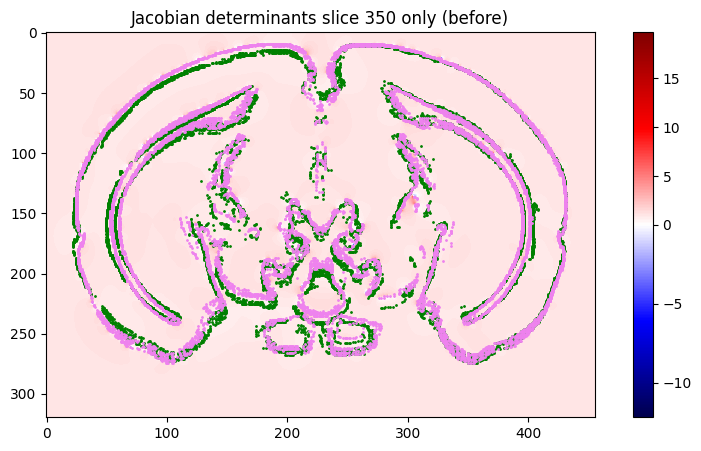

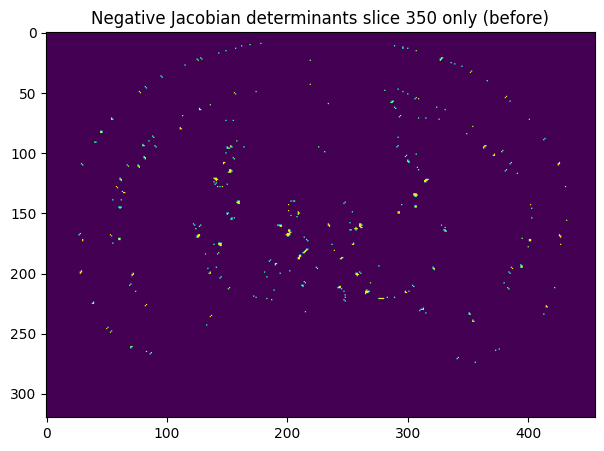

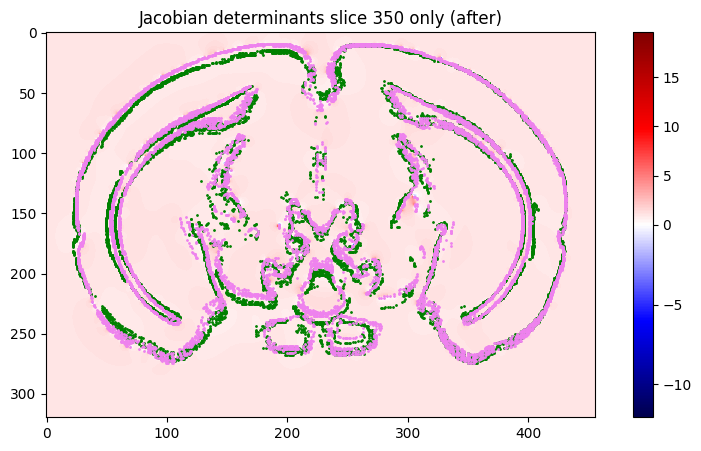

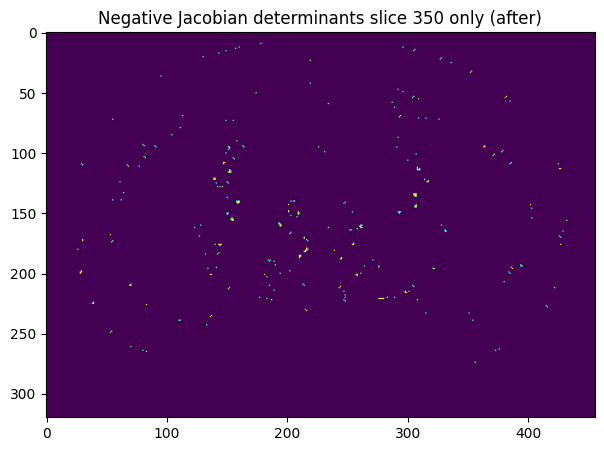

In [8]:
fixed_resolution = np.zeros((10, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints_intersection_removed, fpoints_intersection_removed)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints_intersection_removed[:, 2], mpoints_intersection_removed[:, 1], c="g", s=1)
plt.scatter(fpoints_intersection_removed[:, 2], fpoints_intersection_removed[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

## Remove ORIENTATION outliers from correspondence points

In [4]:
MAX_DIST = 30
MAX_DEG = 60

mpoints_corrected = mpoints.copy()
fpoints_corrected = fpoints.copy()
cvectors_corrected = cvectors.copy()

# Process point orientations
outlier_found = True
num_runs = 0
total_outliers = 0
while outlier_found:
    outlier_found = False
    outlier_indices = []
    num_outliers = 0
    for i in range(len(fpoints_corrected)):
        curr_point = fpoints_corrected[i]
        curr_vector = cvectors_corrected[i]
        #print("Current point:", curr_point)
        neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)

        # Compute the average correspondence vector in the neighborhood
        average_vector = np.mean(cvectors_corrected[neighborhood_idx], axis=0)
        angle_rad, angle_deg = angle_between_vectors(average_vector, curr_vector)
        if angle_deg > MAX_DEG:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            #print(f"Point {i} has a large angle of {angle_deg:.2f} degrees")
            #print(angle_deg)

    # Remove outlier indices from moving and fixed points
    mpoints_corrected = np.delete(mpoints_corrected, outlier_indices, axis=0)
    fpoints_corrected = np.delete(fpoints_corrected, outlier_indices, axis=0)
    cvectors_corrected = np.delete(cvectors_corrected, outlier_indices, axis=0)
    
    print("Number of outliers:", num_outliers, f"out of {len(fpoints)} points")
    total_outliers += num_outliers
    num_runs += 1

print("\nNumber of runs:", num_runs)
print("Number of points removed:", total_outliers)
print("Number of points in the corrected points:", len(fpoints_corrected), "/", len(fpoints))

Number of outliers: 2591 out of 12882 points
Number of outliers: 173 out of 12882 points
Number of outliers: 37 out of 12882 points
Number of outliers: 11 out of 12882 points
Number of outliers: 3 out of 12882 points
Number of outliers: 0 out of 12882 points

Number of runs: 6
Number of points removed: 2815
Number of points in the corrected points: 10067 / 12882


## Compute Jacobian of orientation-filtered points

fdata.shape (10, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.3580322265625s
Computing dy
dy calculated in 3.4100115299224854s
Computing dx
dx calculated in 6.18716835975647s
SITK deformation shape: (10, 320, 456, 3)
fdata.shape (10, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.3510870933532715s
Computing dy
dy calculated in 4.028552770614624s
Computing dx
dx calculated in 6.9423987865448s
SITK deformation shape: (10, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 5204
Before - minimum Jacobian determinant: -12.192625569400679
Before - maximum Jacobian determinant: 19.715043331253668

After - number of negative or zero Jacobian determinants: 2145
After - minimum Jacobian determinant: -6.125750352887978
After - maximum Jacobian determinant: 7.1177792177941335


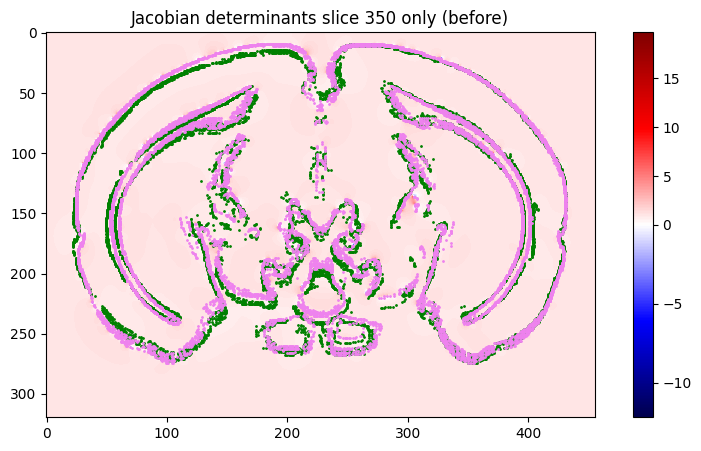

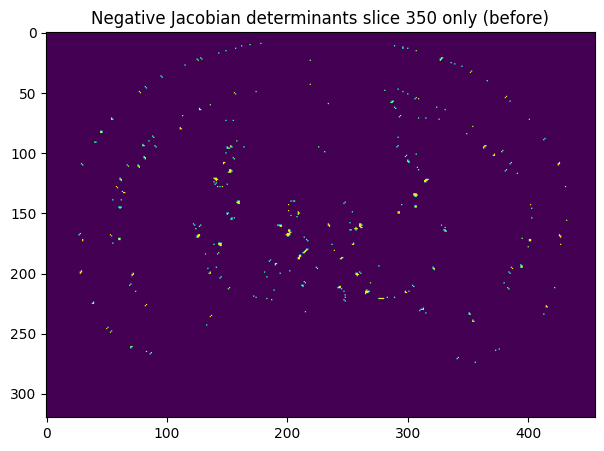

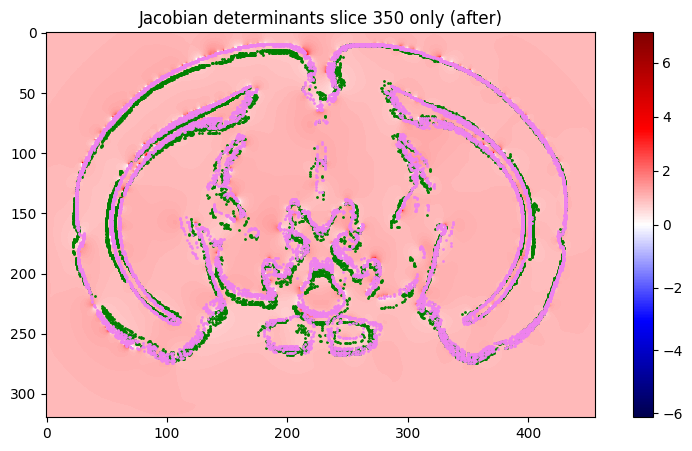

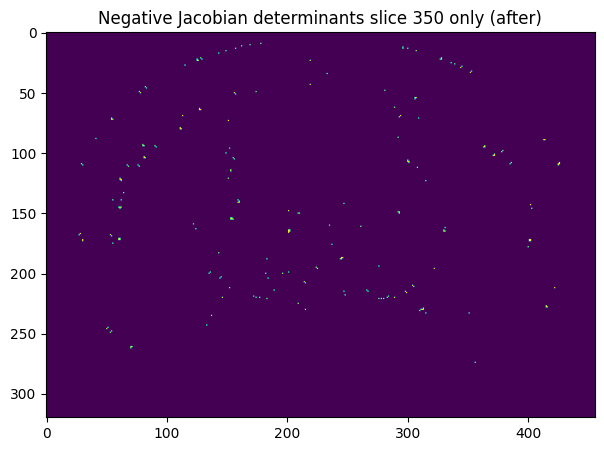

In [6]:
fixed_resolution = np.zeros((10, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints_corrected, fpoints_corrected)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints_corrected[:, 2], mpoints_corrected[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

___

## Remove MAGNITUDE outliers

In [7]:
MAX_MAGNITUDE_MULT_GT = 0.5
MAX_MAGNITUDE_MULT_LT = 0.5
MAX_MAGNITUDE_DIFF_GT = 2
MAX_MAGNITUDE_DIFF_LT = 2
MAX_DIST = 20
DEBUG = False


mpoints_corrected = mpoints.copy()
fpoints_corrected = fpoints.copy()
cvectors_corrected = cvectors.copy()
magnitudes = np.linalg.norm(cvectors_corrected, axis=1)

# Process point magnitudes
outlier_found = True
num_runs = 0
total_outliers = 0
while outlier_found:
    outlier_found = False
    outlier_indices = []
    num_outliers = 0
    for i in range(len(fpoints_corrected)):
        curr_point = fpoints_corrected[i]
        curr_magnitude = magnitudes[i]
        #print("Current point:", curr_point)
        neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)

        # Compute the average correspondence vector in the neighborhood
        average_magnitude = np.mean(magnitudes[neighborhood_idx])
        median_magnitude = np.median(magnitudes[neighborhood_idx])
        std_magnitude = np.std(magnitudes[neighborhood_idx])
        
        if DEBUG:
            print("\nCurrent point:", curr_point)
            print("Current magnitude:", curr_magnitude)
            print("Average magnitude:", average_magnitude)
            print("Median magnitude:", median_magnitude)
            print("Standard deviation of magnitudes:", std_magnitude)
        
        # Remove the point if the magnitude is greater than the average magnitude by a certain threshold
        threshold_gt = max(average_magnitude + average_magnitude * MAX_MAGNITUDE_MULT_GT, 
                           average_magnitude + MAX_MAGNITUDE_DIFF_GT)
        if curr_magnitude > threshold_gt:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            print(f"Point {i} has a larger relative magnitude of {curr_magnitude} > {threshold_gt} ({average_magnitude}).")
            
        # Remove the point if the magnitude is less than the average magnitude by a certain threshold
        threshold_lt = max(average_magnitude - average_magnitude * MAX_MAGNITUDE_MULT_LT, 
                           average_magnitude - MAX_MAGNITUDE_DIFF_LT,
                           0)
        if curr_magnitude < threshold_lt and average_magnitude - MAX_MAGNITUDE_DIFF_LT > 0:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            print(f"Point {i} has a smaller relative magnitude of {curr_magnitude} < {threshold_lt} ({average_magnitude}).")

    # Remove outlier indices from moving and fixed points
    mpoints_corrected = np.delete(mpoints_corrected, outlier_indices, axis=0)
    fpoints_corrected = np.delete(fpoints_corrected, outlier_indices, axis=0)
    cvectors_corrected = np.delete(cvectors_corrected, outlier_indices, axis=0)
    
    print("Number of outliers:", num_outliers, f"out of {len(fpoints_corrected)} points")
    total_outliers += num_outliers
    num_runs += 1
    break

print("\nNumber of runs:", num_runs)
print("Number of points removed:", total_outliers)
print("Number of points in the corrected points:", len(fpoints_corrected), "/", len(fpoints))

Point 60 has a larger relative magnitude of 4.0 > 3.738207738919443 (1.738207738919443).
Point 61 has a smaller relative magnitude of 5.0990195135927845 < 5.2284143698762 (7.2284143698762).
Point 62 has a larger relative magnitude of 8.602325267042627 > 3.8654175275527765 (1.8654175275527765).
Point 63 has a larger relative magnitude of 6.4031242374328485 > 3.858263509549494 (1.8582635095494944).
Point 67 has a smaller relative magnitude of 1.0 < 1.2508637728279919 (2.5017275456559838).
Point 68 has a larger relative magnitude of 4.0 > 3.9033342874427683 (1.9033342874427683).
Point 69 has a larger relative magnitude of 4.242640687119285 > 4.05678540009982 (2.05678540009982).
Point 73 has a larger relative magnitude of 5.0 > 4.122900401834743 (2.1229004018347433).
Point 79 has a smaller relative magnitude of 1.0 < 1.3321635078191916 (2.664327015638383).
Point 82 has a larger relative magnitude of 9.848857801796104 > 7.993896435582471 (5.329264290388314).
Point 85 has a larger relative m

## Compute Jacobian of magnitude-filtered points

fdata.shape (10, 320, 456)


Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.36209726333618164s
Computing dy
dy calculated in 3.444243907928467s
Computing dx
dx calculated in 6.081459045410156s
SITK deformation shape: (10, 320, 456, 3)
fdata.shape (10, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.3507883548736572s
Computing dy
dy calculated in 3.6275277137756348s
Computing dx
dx calculated in 7.562411308288574s
SITK deformation shape: (10, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 5204
Before - minimum Jacobian determinant: -12.192625569400679
Before - maximum Jacobian determinant: 19.715043331253668

After - number of negative or zero Jacobian determinants: 2157
After - minimum Jacobian determinant: -5.612273266334509
After - maximum Jacobian determinant: 16.480199889782863


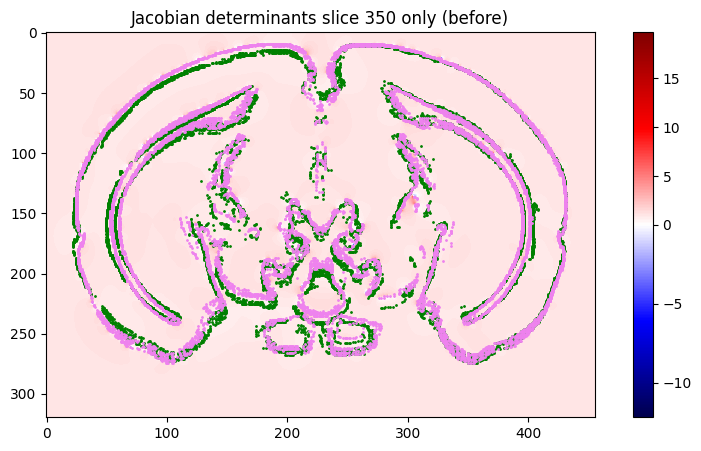

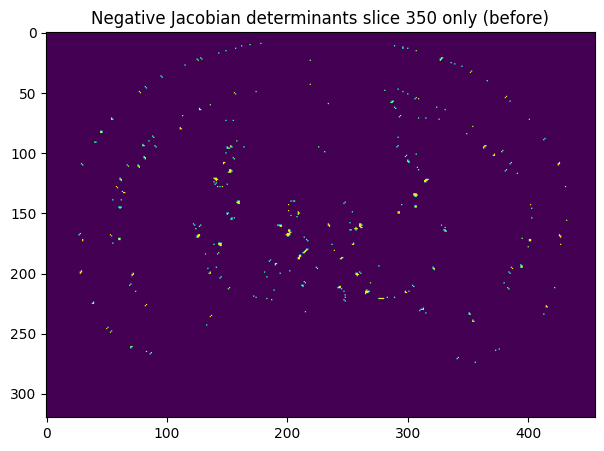

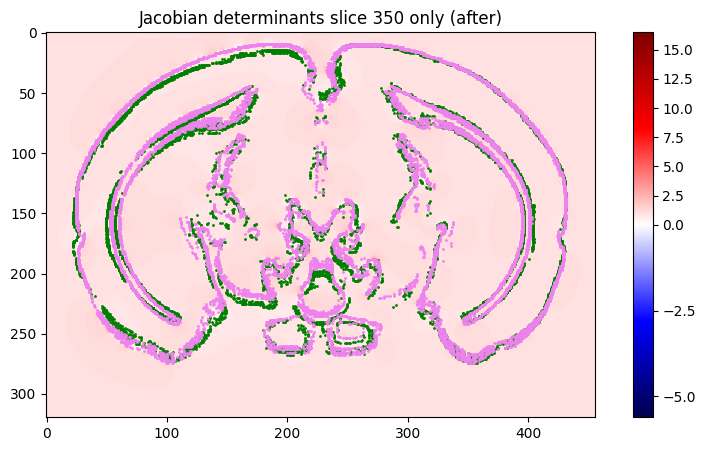

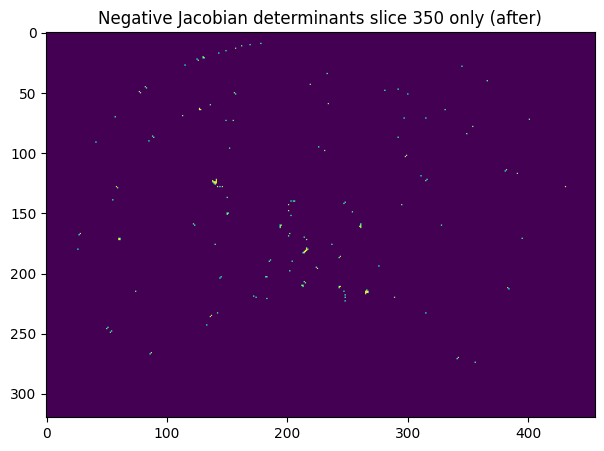

In [8]:
fixed_resolution = np.zeros((10, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints_corrected, fpoints_corrected)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints_corrected[:, 2], mpoints_corrected[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

___
## Combine all

### Run intersection removal

In [7]:
# Start with intersecting point removal
mpoints_intersection_removed, fpoints_intersection_removed = remove_intersections(mpoints, fpoints)
curr_mpoints = mpoints_intersection_removed.copy()
curr_fpoints = fpoints_intersection_removed.copy()
curr_cvectors = curr_fpoints - curr_mpoints

print("Starting number of correspondences:", mpoints.shape[0])
print("Number of correspondences after removing intersections:", mpoints_intersection_removed.shape[0])
print("Number of correspondences removed:", mpoints.shape[0] - mpoints_intersection_removed.shape[0])

100%|██████████| 10/10 [10:17<00:00, 61.80s/it]

Starting number of correspondences: 12882
Number of correspondences after removing intersections: 11981
Number of correspondences removed: 901


### Run orientation removal

In [8]:
# Now remove orientation outliers
MAX_DIST = 30
MAX_DEG = 60

mpoints_corrected = curr_mpoints.copy()
fpoints_corrected = curr_fpoints.copy()
cvectors_corrected = curr_cvectors.copy()

# Process point orientations
outlier_found = True
num_runs = 0
total_outliers = 0
while outlier_found:
    outlier_found = False
    outlier_indices = []
    num_outliers = 0
    for i in range(len(fpoints_corrected)):
        curr_point = fpoints_corrected[i]
        curr_vector = cvectors_corrected[i]
        #print("Current point:", curr_point)
        neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)

        # Compute the average correspondence vector in the neighborhood
        average_vector = np.mean(cvectors_corrected[neighborhood_idx], axis=0)
        angle_rad, angle_deg = angle_between_vectors(average_vector, curr_vector)
        if angle_deg > MAX_DEG:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            #print(f"Point {i} has a large angle of {angle_deg:.2f} degrees")
            #print(angle_deg)

    # Remove outlier indices from moving and fixed points
    mpoints_corrected = np.delete(mpoints_corrected, outlier_indices, axis=0)
    fpoints_corrected = np.delete(fpoints_corrected, outlier_indices, axis=0)
    cvectors_corrected = np.delete(cvectors_corrected, outlier_indices, axis=0)
    
    print("Number of outliers:", num_outliers, f"out of {len(curr_fpoints)} points")
    total_outliers += num_outliers
    num_runs += 1

print("\nNumber of runs:", num_runs)
print("Number of points removed:", total_outliers)
print("Number of points in the corrected points:", len(fpoints_corrected), "/", len(curr_fpoints))

curr_mpoints = mpoints_corrected.copy()
curr_fpoints = fpoints_corrected.copy()
curr_cvectors = curr_fpoints - curr_mpoints

Number of outliers: 2172 out of 11981 points
Number of outliers: 147 out of 11981 points
Number of outliers: 42 out of 11981 points
Number of outliers: 15 out of 11981 points
Number of outliers: 5 out of 11981 points
Number of outliers: 2 out of 11981 points
Number of outliers: 1 out of 11981 points
Number of outliers: 0 out of 11981 points

Number of runs: 8
Number of points removed: 2384
Number of points in the corrected points: 9597 / 11981


### Check intermediary Jacobian

fdata.shape (10, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.3857240676879883s
Computing dy
dy calculated in 4.599902868270874s
Computing dx
dx calculated in 8.094654560089111s
SITK deformation shape: (10, 320, 456, 3)
fdata.shape (10, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.3755321502685547s
Computing dy
dy calculated in 5.150242805480957s
Computing dx
dx calculated in 8.813240051269531s
SITK deformation shape: (10, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 5204
Before - minimum Jacobian determinant: -12.192625569400679
Before - maximum Jacobian determinant: 19.715043331253668

After - number of negative or zero Jacobian determinants: 1464
After - minimum Jacobian determinant: -4.329901525157598
After - maximum Jacobian determinant: 9.53443905331493


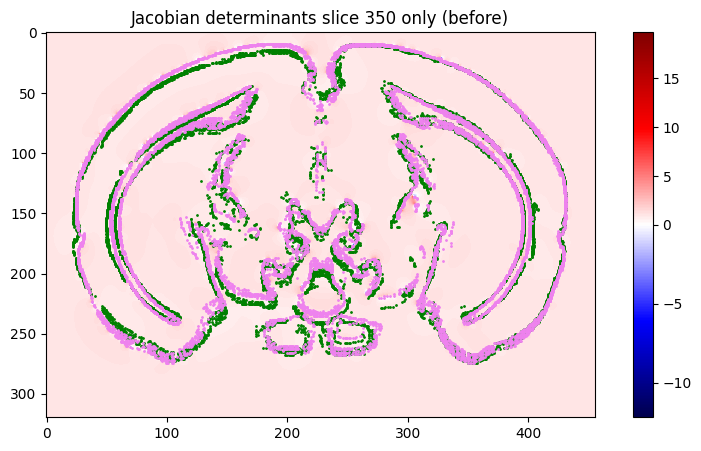

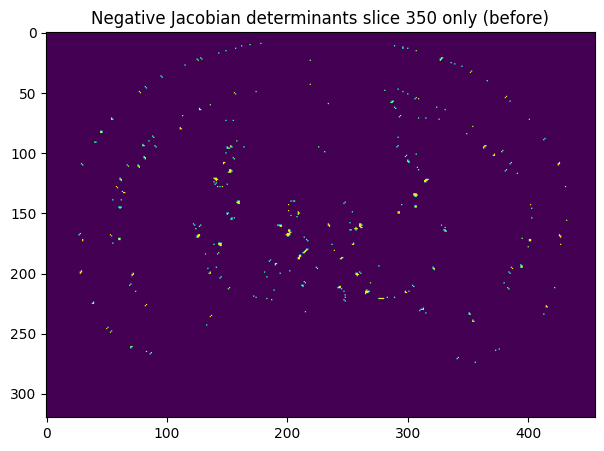

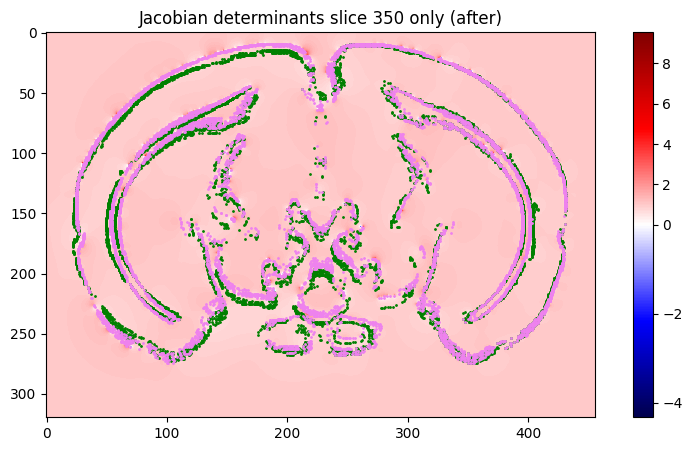

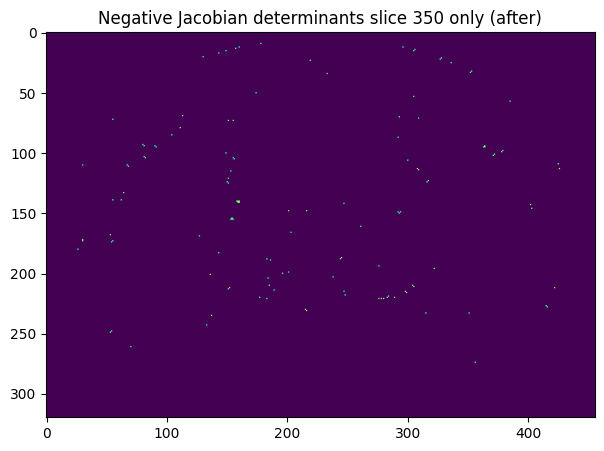

In [9]:
fixed_resolution = np.zeros((10, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, curr_mpoints, curr_fpoints)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(curr_mpoints[:, 2], curr_mpoints[:, 1], c="g", s=1)
plt.scatter(curr_fpoints[:, 2], curr_fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()

### Run magnitude removal

In [10]:
# Now run magnitude
MAX_MAGNITUDE_MULT_GT = 0.5
MAX_MAGNITUDE_MULT_LT = 0.5
MAX_MAGNITUDE_DIFF_GT = 2
MAX_MAGNITUDE_DIFF_LT = 2
MAX_DIST = 20
DEBUG = False


mpoints_corrected = curr_mpoints.copy()
fpoints_corrected = curr_fpoints.copy()
cvectors_corrected = curr_cvectors.copy()
magnitudes = np.linalg.norm(cvectors_corrected, axis=1)

# Process point magnitudes
outlier_found = True
num_runs = 0
total_outliers = 0
while outlier_found:
    outlier_found = False
    outlier_indices = []
    num_outliers = 0
    for i in range(len(fpoints_corrected)):
        curr_point = fpoints_corrected[i]
        curr_magnitude = magnitudes[i]
        #print("Current point:", curr_point)
        neighborhood_idx, neighborhood = get_neighborhood(curr_point, fpoints_corrected, MAX_DIST)

        # Compute the average correspondence vector in the neighborhood
        average_magnitude = np.mean(magnitudes[neighborhood_idx])
        median_magnitude = np.median(magnitudes[neighborhood_idx])
        std_magnitude = np.std(magnitudes[neighborhood_idx])
        
        if DEBUG:
            print("\nCurrent point:", curr_point)
            print("Current magnitude:", curr_magnitude)
            print("Average magnitude:", average_magnitude)
            print("Median magnitude:", median_magnitude)
            print("Standard deviation of magnitudes:", std_magnitude)
        
        # Remove the point if the magnitude is greater than the average magnitude by a certain threshold
        threshold_gt = max(average_magnitude + average_magnitude * MAX_MAGNITUDE_MULT_GT, 
                           average_magnitude + MAX_MAGNITUDE_DIFF_GT)
        if curr_magnitude > threshold_gt:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            print(f"Point {i} has a larger relative magnitude of {curr_magnitude} > {threshold_gt} ({average_magnitude}).")
            
        # Remove the point if the magnitude is less than the average magnitude by a certain threshold
        threshold_lt = max(average_magnitude - average_magnitude * MAX_MAGNITUDE_MULT_LT, 
                           average_magnitude - MAX_MAGNITUDE_DIFF_LT,
                           0)
        if curr_magnitude < threshold_lt and average_magnitude - MAX_MAGNITUDE_DIFF_LT > 0:
            num_outliers += 1
            outlier_indices.append(i)
            outlier_found = True
            print(f"Point {i} has a smaller relative magnitude of {curr_magnitude} < {threshold_lt} ({average_magnitude}).")

    # Remove outlier indices from moving and fixed points
    mpoints_corrected = np.delete(mpoints_corrected, outlier_indices, axis=0)
    fpoints_corrected = np.delete(fpoints_corrected, outlier_indices, axis=0)
    cvectors_corrected = np.delete(cvectors_corrected, outlier_indices, axis=0)
    
    print("Number of outliers:", num_outliers, f"out of {len(fpoints_corrected)} points")
    total_outliers += num_outliers
    num_runs += 1
    break

print("\n\nNumber of runs:", num_runs)
print("Number of points removed:", total_outliers)
print("Number of points in the corrected points:", len(fpoints_corrected), "/", len(curr_fpoints))

curr_mpoints = mpoints_corrected.copy()
curr_fpoints = fpoints_corrected.copy()
curr_cvectors = curr_fpoints - curr_mpoints

Point 58 has a larger relative magnitude of 4.123105625617661 > 3.76143859539314 (1.7614385953931402).
Point 62 has a smaller relative magnitude of 1.0 < 1.2190348363024492 (2.4380696726048985).
Point 63 has a larger relative magnitude of 7.810249675906654 > 3.6845226653431684 (1.6845226653431686).
Point 68 has a larger relative magnitude of 6.4031242374328485 > 3.9301001404473355 (1.9301001404473355).
Point 73 has a smaller relative magnitude of 1.0 < 1.2307793760761139 (2.4615587521522277).
Point 75 has a larger relative magnitude of 9.848857801796104 > 8.440859559491802 (5.6272397063278685).
Point 78 has a larger relative magnitude of 10.295630140987 > 3.84266701216901 (1.8426670121690099).
Point 80 has a larger relative magnitude of 8.54400374531753 > 7.987220507318208 (5.3248136715454715).
Point 92 has a larger relative magnitude of 3.1622776601683795 > 3.0726131915671187 (1.0726131915671187).
Point 103 has a larger relative magnitude of 6.708203932499369 > 2.475273648964213 (0.47

In [11]:
print("Final number of correspondences:", curr_mpoints.shape[0])

Final number of correspondences: 7999


## Compute Jacobian of final combined operation

fdata.shape (10, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.3869333267211914s
Computing dy
dy calculated in 4.197925567626953s
Computing dx
dx calculated in 7.594859838485718s
SITK deformation shape: (10, 320, 456, 3)
fdata.shape (10, 320, 456)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.3821291923522949s
Computing dy
dy calculated in 5.268478631973267s
Computing dx
dx calculated in 9.067306518554688s
SITK deformation shape: (10, 320, 456, 3)

Before - number of negative or zero Jacobian determinants: 5204
Before - minimum Jacobian determinant: -12.192625569400679
Before - maximum Jacobian determinant: 19.715043331253668

After - number of negative or zero Jacobian determinants: 479
After - minimum Jacobian determinant: -2.039899489979914
After - maximum Jacobian determinant: 7.16007122600273


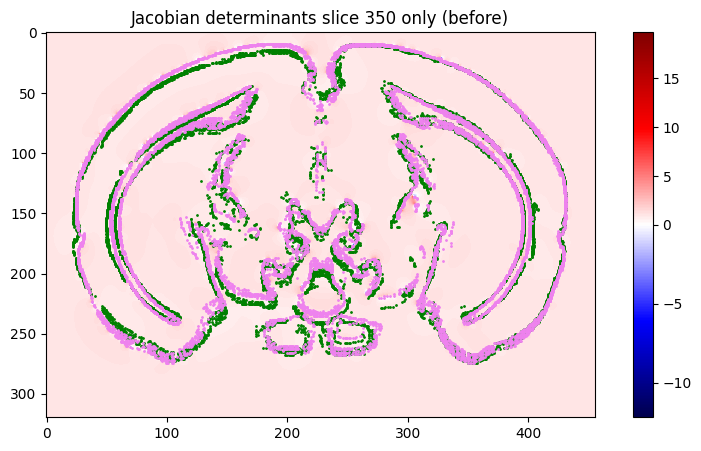

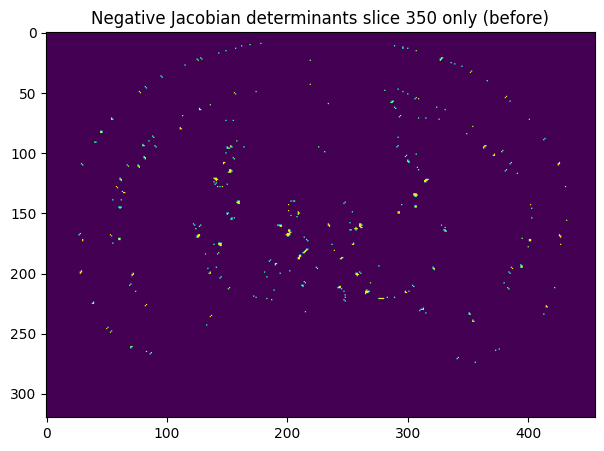

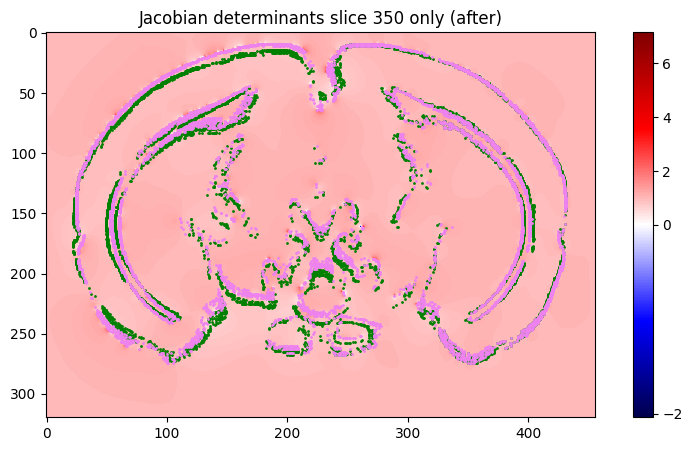

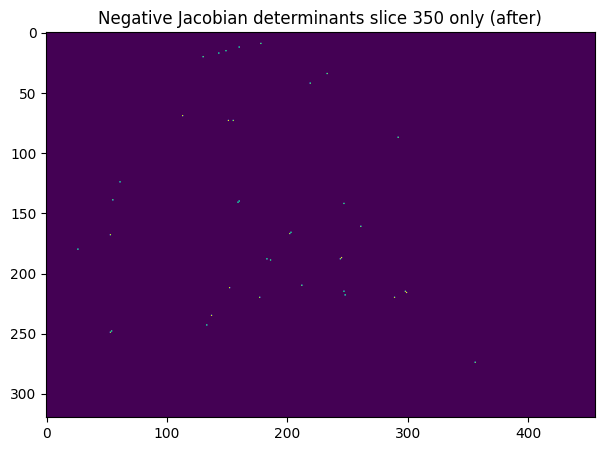

In [12]:
fixed_resolution = np.zeros((10, 320, 456))

# Compute the 3D Laplacian of the ORIGINAL points and retrieve the Jacobian determinant field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet = jacobian.sitk_jacobian_determinant(deformation)

# Compute the 3D Laplacian of the NEW CORRECTED points and retrieve the Jacobian determinant field
deformation_corrected, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, curr_mpoints, curr_fpoints)
jdet_corrected = jacobian.sitk_jacobian_determinant(deformation_corrected)

# Print the number of negative or zero Jacobian determinants
print("\nBefore - number of negative or zero Jacobian determinants:", np.sum(jdet <= 0))
print("Before - minimum Jacobian determinant:", jdet.min())
print("Before - maximum Jacobian determinant:", jdet.max())
print()

print("After - number of negative or zero Jacobian determinants:", np.sum(jdet_corrected <= 0))
print("After - minimum Jacobian determinant:", jdet_corrected.min())
print("After - maximum Jacobian determinant:", jdet_corrected.max())

# Plot the Jacobian determinant values of the original
norm = mcolors.TwoSlopeNorm(vmin=min(jdet.min(), -1), vcenter=0, vmax=jdet.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (before)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (before)")
plt.show()

# Plot the Jacobian determinant values of the corrected
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_corrected.min(), -1), vcenter=0, vmax=jdet_corrected.max())
plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0], cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(curr_mpoints[:, 2], curr_mpoints[:, 1], c="g", s=1)
plt.scatter(curr_fpoints[:, 2], curr_fpoints[:, 1], c="violet", s=1)
plt.title("Jacobian determinants slice 350 only (after)")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(jdet_corrected[0] <= 0, cmap='viridis')
plt.title("Negative Jacobian determinants slice 350 only (after)")
plt.show()